## Business Understanding
For the 3rd questions I want to find out the answer for what factors are related to the job satisfaction. 
I use the data from the Stack Overflow survey answered by more than 64,000 reviewers, with the personal information, coding experience, attitude towards coding and etc.

To answer this question we need to use the data related to the job satisfaction such as the employment status, education level, remote work policy, company type, company size and etc.

## Data Understanding
To get started let's read in the necessary libraries and take a look at some of our columns of interest.

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We pick the factors considered to be related to Job Satisfaction.
Note that the reason why I don't choose Expected Salary is because it's mutually exclusive with Salary and has a low amount of non-null data.

In [233]:
# Pick relevent columns
rel_col = [
    'JobSatisfaction', 'CareerSatisfaction', 'EmploymentStatus', 
    'FormalEducation', 'HomeRemote', 'CompanySize', 'CompanyType', 'HoursPerWeek',
    'Overpaid', 'Gender', 'Race', 'Salary'
    ]
df_rel = df[rel_col]

Let's look into the quantative variables first, from the description below it seems all quantative variables has null values.

In [234]:
print('Total rows:', len(df_rel))
df_rel.describe()

Total rows: 51392


,JobSatisfaction,CareerSatisfaction,HoursPerWeek,Salary
count,40376.000000,42695.000000,20600.000000,12891.000000
mean,6.957078,7.300574,3.952282,56298.480641
std,2.167652,1.955444,7.564722,39880.905277
min,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6.000000,1.000000,26440.371839
50%,7.000000,8.000000,1.000000,50000.000000
75%,8.000000,9.000000,4.000000,80000.000000
max,10.000000,10.000000,40.000000,197000.000000


The above are variables that python is treating as numeric variables, and therefore, we could send them into our linear model blindly to predict the response. Let's take a quick look at our data first.

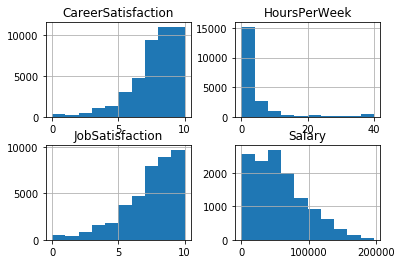

In [204]:
df_rel.hist();

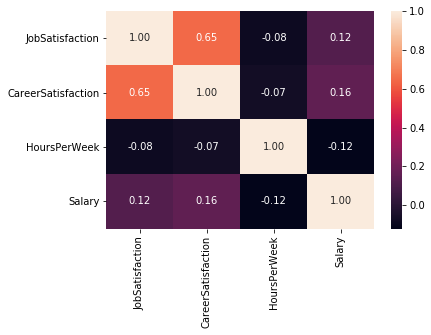

In [205]:
sns.heatmap(df_rel.corr(), annot=True, fmt=".2f");

Also check the distribution of the values for those catigorical variables. From the result below it seems there are some answers needs to be convert to null values. Also some of the categories are too specific, we can combine the answer options into rougher categories.

In [206]:
# Check what kinds of values do the categorical variables contain 
for col in df_rel.select_dtypes(include = ['object']).columns:
    print(col)
    print(df_rel[col].value_counts())
    print()

EmploymentStatus
Employed full-time                                      36148
Independent contractor, freelancer, or self-employed     5233
Employed part-time                                       3180
Not employed, and not looking for work                   2791
Not employed, but looking for work                       2786
I prefer not to say                                      1086
Retired                                                   168
Name: EmploymentStatus, dtype: int64

FormalEducation
Bachelor's degree                                                    21609
Master's degree                                                      11141
Some college/university study without earning a bachelor's degree     8129
Secondary school                                                      5908
Doctoral degree                                                       1308
I prefer not to answer                                                1109
Primary/elementary school                    

## Prepare Data
Let's begin with cleaning the categorical variables.
Seems some of the categorical variables' values needs to be limited. For example we can limite the answers to EmploymentStatus to be only employed, since those umemployed or retired don't have a job thus has no job satisfaction.

In [207]:
# Seems some of the categorical variables' values needs to be limited
# for EmploymentStatus, exclude those not employed or retired
possible_vals = [
    "EmploymentStatus", "Employed full-time", 
    "Independent contractor, freelancer, or self-employed", "Employed part-time",
    "I prefer not to say"
    ]
df_rel = df_rel[df_rel.EmploymentStatus.isin(possible_vals)]
# Replace "I prefer not to say" to NaN
di = {"I prefer not to say" : None}
df_rel = df_rel.replace({"EmploymentStatus" : di})

Also note that there are some answers like "I prefer not to answer" and "I don't know", which can be recognized as null values.

In [ ]:
# for FormalEducation, too many categories, merge to big categories
# Replace "I prefer not to anser" to NaN
di = {
    "I prefer not to answer" : None, "Primary/elementary school" : "Below Secondary School",
    "Primary/elementary school" : "Below Secondary School", 
    "I never completed any formal education" : "Below Secondary School",
    "Professional degree" : "Master's degree"
    }
df_rel = df_rel.replace({"FormalEducation": di})

# for HomeRemote, replace "It's complicated" to NaN
di = {"It's complicated" : None}
df_rel = df_rel.replace({"HomeRemote" : di})

# for CompanySize, replace "I don't know" and "I prefer not to answer" to NaN
di = {
    "I don't know" : None, 
    "I prefer not to answer" : None
    }
df_rel = df_rel.replace({"CompanySize" : di})

# for CompanyType, replace "I don't know", "Something else" and "I prefer not to answer" to NaN
# trim the types into Private, Public, Government, and Startup
di = {
    "I don't know" : None, "I prefer not to answer" : None, "Something else" : None,
    "Privately-held limited company, not in startup mode" : "Private", 
    "Publicly-traded corporation" : "Public", "Sole proprietorship or partnership, not in startup mode" : "Private",
    "Government agency or public school/university" : "Government", "Venture-funded startup" : "Startup",
    "Pre-series A startup" : "Startup", "State-owned company" : "Government"
    }
df_rel = df_rel.replace({"CompanyType": di})

From the distribution of values we can also identify some columns that are not suitble for prediction of the job satisfaction.


In [ ]:
# drop gender since there's large imbalance between mail and female
df_rel = df_rel.drop('Gender', axis=1)

# drop race since there's large imbalance between White and others
df_rel = df_rel.drop('Race', axis=1)

# remove career satisfaction since it has big corelation with job satisfaction
df_rel = df_rel.drop('CareerSatisfaction', axis=1)

Let's see what the categorical variables look like after the cleaning.

In [208]:
# Check what kinds of values do the categorical variables contain after the cleaning
for col in df_rel.select_dtypes(include = ['object']).columns:
    print(col)
    print(df_rel[col].value_counts())
    print()

EmploymentStatus
Employed full-time                                      36148
Independent contractor, freelancer, or self-employed     5233
Employed part-time                                       3180
Name: EmploymentStatus, dtype: int64

FormalEducation
Bachelor's degree                                                    20318
Master's degree                                                      11386
Some college/university study without earning a bachelor's degree     7134
Secondary school                                                      3912
Doctoral degree                                                       1260
Below Secondary School                                                 786
Name: FormalEducation, dtype: int64

HomeRemote
A few days each month                                      15452
Never                                                      13972
All or almost all the time (I'm full-time remote)           4905
Less than half the time, but at least one day each

To handle the null values, I defined a function.
As for the quantative variables, simply replace the null values with the mean value of the column.
As for the categorical variables, just get dummies ignoring the null values.

In [209]:
# Define the function to clean data: replace NaN with mean value for quantative variables, create dummies for 
# catagorical variables, and return df
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - cleaned dataframe
    
    This function cleans df using the following steps to produce df:
    1. Drop all the rows with no Job Satisfaction
    2. For each numeric variable in df, fill the column with the mean value of the column.
    3. Create dummy columns for all the categorical variables in df, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['JobSatisfaction'], axis=0)

    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    return df

df_rel = clean_data(df_rel)

/Users/clin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Data Modeling
To best train our model, I first use linear model, do the evaluation, and then try to use random forest model and parameter optimization methods to improve the model.
I also use cutoffs to determine the best number of features to be used for modeling.

### Linear Model the Evaluation
First use linear modeling.

In [210]:
# Train model and predict

X = df_rel.drop('JobSatisfaction', axis=1)
y = df_rel['JobSatisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) # If this model was to predict for new individuals, we probably would want
               # worry about train/test splits and cross-validation, but for now I am most 
               # interested in finding a model that just fits all of the data well
# fit the model
y_test_preds = lm_model.predict(X_test)

# scores
print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #metrics to assess fit include Rsquared and MSE.

0.03904628840234092
4.524004608145256


In [211]:
preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']
preds_vs_act.head()

,actual,preds,diff
0,7.0,7.305802,-0.305802
1,8.0,7.678331,0.321669
2,0.0,6.535253,-6.535253
3,7.0,7.345647,-0.345647
4,4.0,6.933708,-2.933708


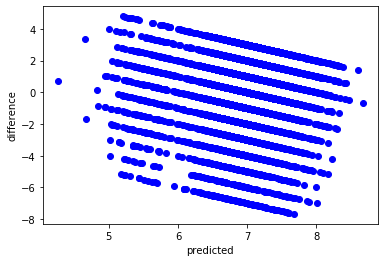

In [212]:
### plot how far our predictions are from the actual values compaired to the predicted
plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

Seems there are quite big bias when the score is low or high.
Let's what the best number of features to use based on the test set performance will be.

In [213]:
### Let's see what be the best number of features to use based on the test set performance
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True) 
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

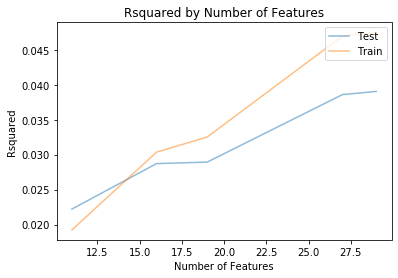

In [214]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

We can see the more features are used the higher the test set performance will be.

In [215]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)

In [217]:
# check the scale of coefficients
coefs_df.sort_values('abs_coefs', ascending=False)

,est_int,coefs,abs_coefs
25,Overpaid_Greatly underpaid,-1.288839,1.288839
26,Overpaid_Neither underpaid nor overpaid,0.607862,0.607862
5,FormalEducation_Doctoral degree,0.422809,0.422809
27,Overpaid_Somewhat overpaid,0.357475,0.357475
13,HomeRemote_Never,-0.322010,0.322010
24,CompanyType_Startup,0.311625,0.311625
7,FormalEducation_Secondary school,0.300636,0.300636
10,HomeRemote_All or almost all the time (I'm ful...,0.252870,0.252870
18,"CompanySize_5,000 to 9,999 employees",-0.198875,0.198875
28,Overpaid_Somewhat underpaid,-0.155702,0.155702


Interesting, it seems the most factor of Job Satisfaction is whether the employee get overpaid, also employees in Startups seems more happy, and those work for big companies are unhappy, also the more time working from home the higher satisfaction

### Randomforest Model the Evaluation

In [220]:
### Use randomforest instead of linear model
from sklearn.ensemble import RandomForestRegressor

### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response

        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    rf_model = RandomForestRegressor() 
    rf_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

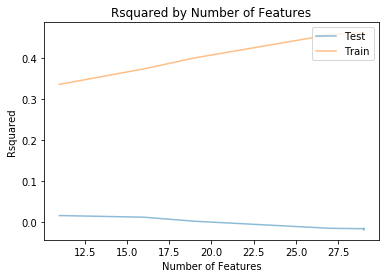

In [221]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs)

Oops, It seems if use randomforest it will get overfitted.

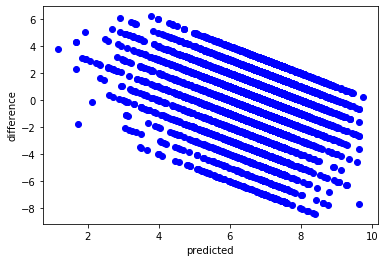

In [223]:
y_test_preds = rf_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

### Improve the Randomforest Model using parameter optimization.

In [224]:
# use GridSearchCV to search for optimal hyper parameters

from sklearn.model_selection import GridSearchCV

### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True, param_grid=None):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        if param_grid==None:
            rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

        else:
            rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
            rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
            
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    if param_grid==None:
        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

    else:
        rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
        rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
    rf_model.fit(X_train, y_train)
     
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


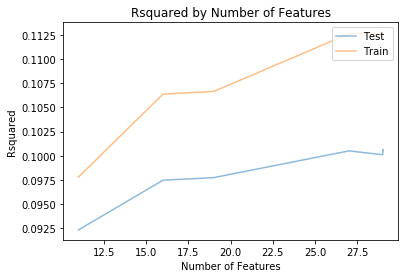

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [225]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
params = {'n_estimators': [10, 100, 1000], 'max_depth': [1, 5, 10, 100]}
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs, param_grid=params)

It seems the linear model has better performance than random forest here.

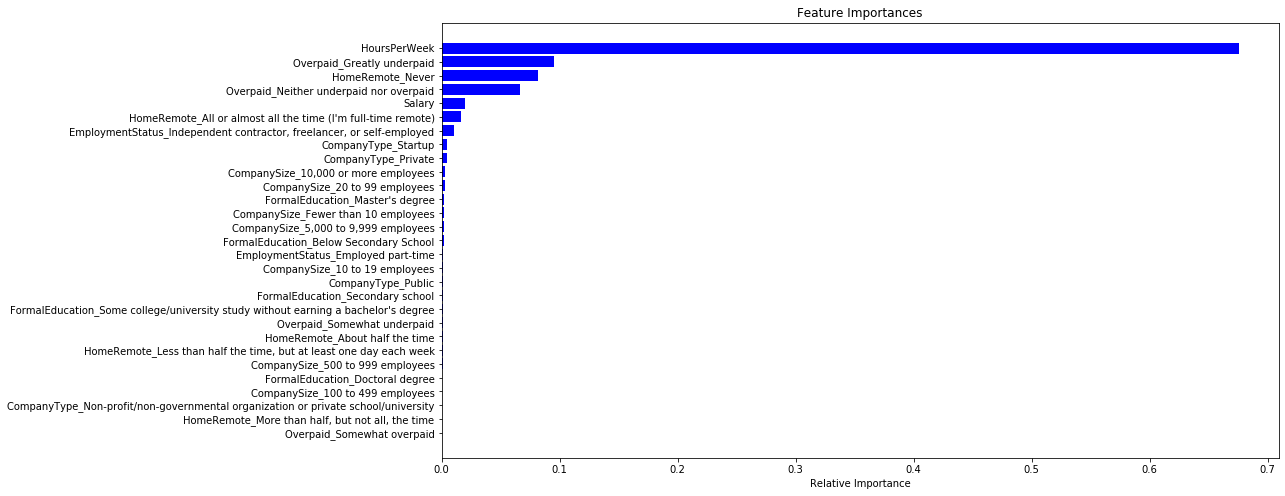

In [228]:
features = X_train.columns
importances = rf_model.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [229]:
# Rsqured not very good